# Data Handling and Basic Analysis (FB2NRP)
*Version 0.0.3*

This workbook introduces the foundations of **data handling and basic analysis**, using a small **synthetic RCT dataset** that mimics some nutrition trials:

- Blood pressure change after different amounts of coffee  
- Blood glucose after different cereals  
- Appetite VAS after different test foods  

The data are **simulated** and include **age** and **sex**.  
The dataset is made available as a pandas DataFrame called `df` by the **bootstrap cell above**.

The workbook is designed to work both as:

- a **lecture resource** (with explanations and examples), and  
- a **practical notebook** (with commented Python code cells).

By the end of the workbook you should be able to:

- Distinguish between **categorical**, **ordinal**, and **continuous** variables  
- Explore a dataset with `df.info()` and `df.describe()`  
- Compute and report **mean**, **SD**, **median**, **IQR** for continuous data  
- Understand common **distributions** (normal, log-normal, *t*, Poisson) at a light-touch level  
- Explore **distributions** and use Q–Q plots to assess normality  
- Create **contingency tables** for categorical data  
- Describe data appropriately for publication (e.g. a simple **Table 1**)  
- Understand the basics of **NHST** (H0 vs H1), **p-values**, and **95% CIs**  
- See why p = 0.05 is not a magical threshold (we will use **α = 0.0314**)  
- Compare two and more groups using **parametric** and **non-parametric** tests  
- Remember that **statistics are tools, not an oracle**


## 0. From raw data to analysis: the basic flow

In almost every quantitative study, the **flow of analysis** is:

1. **View the data**  
   - Load the dataset into your software (here: pandas DataFrame `df`).  
   - Look at a few rows (`df.head()`).  
   - Check variable names, data types, and obvious issues (`df.info()`).

2. **Clean the data**  
   - Handle missing values (decide when to impute, when to drop).  
   - Detect obviously impossible values (e.g. age = −5, VAS > 100).  
   - Fix coding problems (e.g. "Male" vs "M" vs "m").

3. **Standardise the data**  
   - Ensure variables use **consistent units** (e.g. all blood pressure in mmHg, all glucose in mmol/L).  
   - Recode categories in a consistent way (e.g. `F`/`M`, or 0/1 with clear labels).

4. **Analyse the data**  
   - Start with **descriptive statistics** (means, medians, counts, percentages).  
   - Present a clear **Table 1** of baseline characteristics.  
   - Move to **statistical inference** (p-values, confidence intervals, models) only once you understand the data.

In this workbook we follow the same structure: first **understand and describe**, then **compare and infer**.


In [ ]:
# ============================================================
# FB2NRP bootstrap cell (works both locally and in Colab)
#
# What this cell does:
# - Locally: expects you to open the notebook from *inside*
#   the fb2nrp-datahandling repository (e.g. repo/notebooks).
#   It walks up the directory tree to find scripts/bootstrap.py.
# - In Colab: if the repo is not found, it clones it from GitHub
#   into /content/fb2nrp-datahandling.
# - Loads and runs scripts/bootstrap.py.
# - Generates a synthetic dataset and makes it available as `df`.
# ============================================================

import os
import sys
import pathlib
import subprocess
import importlib.util

REPO_URL = "https://github.com/ggkuhnle/fb2nrp-datahandling.git"
REPO_DIR = "fb2nrp-datahandling"

def in_colab() -> bool:
    """Return True if running inside Google Colab."""
    try:
        import google.colab  # type: ignore  # noqa: F401
        return True
    except ImportError:
        return False

# Make sure the process cwd is valid
try:
    cwd = pathlib.Path.cwd()
except FileNotFoundError:
    raise RuntimeError(
        "Current working directory no longer exists.\n"
        "Please restart the kernel from inside the fb2nrp-datahandling repository "
        "(e.g. open the notebook from repo/notebooks and try again)."
    )

# Try to find the repo root by walking up the directory tree
repo_root = None
for parent in [cwd] + list(cwd.parents):
    if (parent / "scripts" / "bootstrap.py").is_file():
        repo_root = parent
        break

if repo_root is not None:
    # We are somewhere inside an existing clone (local or Colab)
    os.chdir(repo_root)
    repo_root = pathlib.Path.cwd()
    print(f"Repository root detected at: {repo_root}")
else:
    # Repo not found by walking up
    if in_colab():
        # In Colab: clone into /content/fb2nrp-datahandling
        base_dir = pathlib.Path("/content")
        os.chdir(base_dir)
        repo_root = base_dir / REPO_DIR
        if not repo_root.is_dir():
            print(f"Cloning repository from {REPO_URL} into {repo_root} ...")
            subprocess.run(["git", "clone", REPO_URL, str(repo_root)], check=True)
        else:
            print(f"Using existing repository at {repo_root}")
        os.chdir(repo_root)
        repo_root = pathlib.Path.cwd()
        print(f"Repository root set to: {repo_root}")
    else:
        # Local but not inside the repo: fail with a clear message
        raise RuntimeError(
            "Could not find fb2nrp-datahandling repository root.\n"
            "Please make sure you open this notebook from inside the "
            "`fb2nrp-datahandling` repository (e.g. repo/notebooks) and "
            "then re-run this cell."
        )

# ------------------------------------------------------------
# 2. Load scripts/bootstrap.py as a module and call init()
# ------------------------------------------------------------

bootstrap_path = repo_root / "scripts" / "bootstrap.py"

if not bootstrap_path.is_file():
    raise FileNotFoundError(
        f"Could not find {bootstrap_path}. "
        "Please check that the fb2nrp-datahandling repository structure is intact."
    )

spec = importlib.util.spec_from_file_location("fb2nrp_bootstrap", bootstrap_path)
bootstrap = importlib.util.module_from_spec(spec)
sys.modules["fb2nrp_bootstrap"] = bootstrap
spec.loader.exec_module(bootstrap)

# CTX will contain paths and settings defined in bootstrap.py
CTX = bootstrap.init()

for name in ["REPO_NAME", "REPO_URL"]:
    if hasattr(bootstrap, name):
        globals()[name] = getattr(bootstrap, name)

print("Bootstrap completed successfully.")
print("The context object is available as `CTX`.")


In [ ]:
# ============================================================
# Setup: scientific Python libraries and plotting style
#
# Assumes the bootstrap cell above has already created:
#   - CTX : context object with paths and settings
# ============================================================

# Data handling and numerical computing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests and distributions
import scipy.stats as st

# Display options (optional but helpful)
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)

# Plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

print("Libraries loaded.")


In [ ]:
# ============================================================
# Generate the synthetic dataset for this workbook
# ============================================================

# The helper function simulate_practical_data() returns a
# small DataFrame that mimics some nutrition RCT practicals.
from scripts.helpers import simulate_practical_data, VARIABLES

# Use a fixed seed for reproducibility
df = simulate_practical_data(seed=11088)

print(f"Dataset loaded with {len(df)} rows and {df.shape[1]} columns.")


## 1. Study variables and data types

Before running any analysis, we need to understand **what kind of variables** we have.  
Different types require different summaries and different statistical tests.

### 1.1 Overview of variable types

| Variable type | What it means | Examples | How to summarise | Appropriate analyses |
|--------------|---------------|----------|------------------|----------------------|
| **Categorical (nominal)** | Distinct labels with **no natural order**. Values are names only. | Sex (F/M), coffee arm (low/medium/high), cereal arm, favourite animal (hippo). | Counts and percentages. | Chi-squared tests, Fisher’s exact test, logistic/multinomial regression. |
| **Ordinal** | Categories **with a natural order**, but **unequal spacing** between levels. | Likert scale 1–5, hunger rating (low/medium/high), symptom severity. | Counts/percentages; sometimes median (IQR) of coded scores with justification. | Mann–Whitney test, Kruskal–Wallis, ordinal logistic regression. |
| **Continuous (or approx. continuous)** | Numerical values where **differences and averages are meaningful**. Often many possible values. | Age (years), BP change (mmHg), glucose, VAS (0–100, often treated as continuous). | Mean ± SD (if symmetric), or median (IQR) if skewed. | t-tests, ANOVA, correlation, linear regression; non-parametric alternatives if needed. |

A few reminders:

- Coding categorical data as numbers **does not** turn them into continuous variables.  
- Ordinal scales can sometimes be treated as continuous **only** if many levels and behaved distributions make it reasonable.  
- VAS scores (0–100) occupy a grey zone: technically ordinal, often acceptable to treat as continuous in nutrition.


### 1.2 Variables in our synthetic dataset

Our synthetic dataset `df` contains (one row per participant):

| Variable | Type | Description |
|----------|------|-------------|
| `sex` | Categorical (nominal) | Participant sex (F/M) |
| `age` | Continuous | Age in years |
| `coffee_arm` | Categorical (nominal) | Intervention: low / medium / high coffee |
| `cereal_arm` | Categorical (nominal) | Cereal: bran / cornflakes / muesli |
| `food_arm` | Categorical (nominal) | Test food: apple / biscuit / yoghurt |
| `bp_change` | Continuous | Change in blood pressure (mmHg) |
| `glucose` | Continuous | Postprandial blood glucose (arbitrary units) |
| `appetite_vas` | Continuous / ordinal | VAS 0–100; treated here as approx. continuous |

For completeness, we can also display the helper metadata `VARIABLES` that describes each column.


In [ ]:
VARIABLES


## 2. First look at the dataset

We start with a **quick overview** of `df`:

- `df.head()` shows the first few rows (useful to spot obvious coding issues).  
- `df.info()` summarises variables, data types, and missing values.

This is the **"view"** step of the analysis flow.


In [ ]:
# First few rows of the dataset
df.head()


In [ ]:
# Overall structure of the DataFrame (types, missingness)
df.info()


### 2.1 Missing values and impossible values

We should also check for **missing values** and obviously **impossible values** (e.g. negative age, VAS > 100, glucose = 0 in a living participant).

Our simulator does not generate missing or impossible values, but in real data these checks are essential and sometimes the longest part of the analysis.


In [ ]:
# Count of missing values per variable
df.isna().sum()


## 3. Describing continuous variables

For continuous variables (age, BP change, glucose, VAS) we want to describe:

1. **Where the values tend to lie** (central tendency).  
2. **How much they vary** (dispersion).  
3. **What the distribution looks like** (shape).

In this section we first look at **distributions**, then define **central tendency and dispersion**, and finally compute appropriate **summary statistics**.


### 3.1 Distributions and how to look at them

Many statistical methods assume that variables follow certain **distributions**.  
For this workbook, four are particularly useful:

- **Normal distribution** (bell-shaped, symmetric).  
- **Log-normal distribution** (skewed; log of the variable is normal).  
- **t-distribution** (like normal, but with heavier tails; used in t-tests).  
- **Poisson distribution** (for **counts**, especially of rare events).

We do not need the formulas; we just need to recognise their shapes and know when they are plausible models.

We usually look at distributions in two ways:

- **Histograms/density plots**: show the shape of the data.  
- **Q–Q plots (Quantile–Quantile plots)**: compare the quantiles of the data to those of a reference distribution (often normal).


#### 3.1.1 Normal and log-normal distributions

- A variable is **approximately normal** when its histogram is symmetric and bell-shaped.  
  - Example: adult height, measurement error, often blood pressure in reasonably homogeneous groups.
- A variable is **log-normal** when its **logarithm** is approximately normal.  
  - Example: many biomarkers and concentrations, where values are strictly positive and skewed to the right.

Below we simulate data from a normal distribution to illustrate the shape.


In [ ]:
# Simulated example: normal distribution
rng = np.random.default_rng(11088)
normal_sample = rng.normal(loc=0, scale=1, size=2000)

sns.histplot(normal_sample, kde=True)
plt.title("Simulated normal distribution (mean = 0, SD = 1)")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


Below we simulate data from a log-normal distribution. Notice the **right-skewed** shape: many observations near the lower end, with a long tail of higher values.


In [ ]:
# Simulated example: log-normal distribution
lognormal_sample = rng.lognormal(mean=0, sigma=0.6, size=2000)

sns.histplot(lognormal_sample, kde=True)
plt.title("Simulated log-normal distribution")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


#### 3.1.2 t-distribution

The **t-distribution** appears when we:

- estimate means from **small samples**, and  
- use the **sample SD** instead of the true population SD.

It looks similar to the normal distribution but has **heavier tails**, especially with **small degrees of freedom (df)**.  
This matters for **t-tests** and confidence intervals based on small samples.

Below we plot t-distributions with different degrees of freedom and compare them to the standard normal.


In [ ]:
# t-distributions vs standard normal
x = np.linspace(-4, 4, 400)
pdf_normal = st.norm.pdf(x, loc=0, scale=1)
pdf_t3 = st.t.pdf(x, df=3)
pdf_t10 = st.t.pdf(x, df=10)
pdf_t30 = st.t.pdf(x, df=30)

plt.plot(x, pdf_normal, label="Normal")
plt.plot(x, pdf_t3, linestyle="--", label="t, df=3")
plt.plot(x, pdf_t10, linestyle=":", label="t, df=10")
plt.plot(x, pdf_t30, linestyle="-.", label="t, df=30")
plt.title("Normal vs t-distributions")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


#### 3.1.3 Poisson distribution

The **Poisson distribution** is a model for **counts** of events in a fixed time or space, especially when events are:

- **independent**, and  
- individually **rare**.

Examples:

- Number of adverse events per participant in a trial.  
- Number of emergency admissions per day in a small hospital.  
- Number of typing errors per page in a report (for some of us).

It has a single parameter **λ (lambda)**, which is both the **mean** and the **variance** of the distribution.

Below we show the probabilities for a Poisson distribution with λ = 2.5.


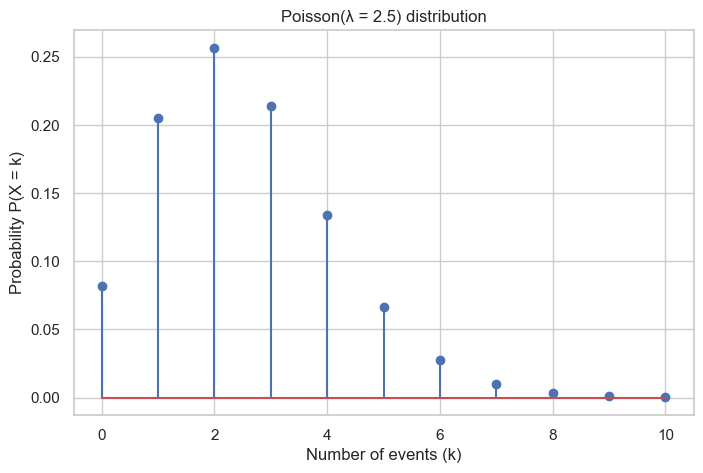

In [58]:
# Poisson distribution example (lambda = 2.5)
lam = 2.5
k_values = np.arange(0, 11)  # 0 to 10 events
pmf = st.poisson.pmf(k_values, mu=lam)

plt.stem(k_values, pmf)
plt.title("Poisson(λ = 2.5) distribution")
plt.xlabel("Number of events (k)")
plt.ylabel("Probability P(X = k)")
plt.show()


#### 3.1.4 Looking at our data: BP change

Now we return to our dataset and look at the distribution of **blood pressure change** (`bp_change`).

We use:

- a **histogram** with a smooth density estimate, and  
- a **Q–Q plot** against the normal distribution.


In [ ]:
# Histogram and density for blood pressure change
sns.histplot(df["bp_change"], kde=True)
plt.title("Distribution of BP change")
plt.xlabel("BP change (mmHg)")
plt.ylabel("Count")
plt.show()


A **Q–Q plot** compares the quantiles of our data to those of a perfect normal distribution.

- If the points lie roughly on a straight line, the data are not wildly inconsistent with normality.  
- Systematic curves (S-shape, heavy tails) suggest deviations such as skewness or outliers.


In [ ]:
# Q–Q plot to assess normality of BP change
st.probplot(df["bp_change"], dist="norm", plot=plt)
plt.title("Q–Q plot of BP change")
plt.show()


### 3.2 Central tendency and dispersion

Once we have a sense of the **shape** of a distribution, we can talk about:

- **Central tendency** – where the values tend to lie.  
- **Dispersion (spread)** – how much they vary around the centre.

Common choices:

- **Mean** (average) and **standard deviation (SD)**  
  - Most useful when the distribution is not too skewed.  
- **Median** and **interquartile range (IQR)**  
  - More robust to skewed distributions and outliers.

Choice of summary should be guided by the **distributional shape**, not by habit.


### 3.3 Mean, SD, median, and IQR

Definitions:

- **Mean**: add up all observations and divide by the number of observations.  
- **Standard deviation (SD)**: describes how far, on average, observations are from the mean.  
- **Median**: the middle value when the data are ordered (50% below, 50% above).  
- **Interquartile range (IQR)**: difference between the 75th percentile (Q3) and 25th percentile (Q1).

Rules of thumb:

- If the distribution is **roughly symmetric** → report *mean ± SD*.  
- If the distribution is **clearly skewed** → report *median (IQR)*.

In practice, many papers report both, at least in supplementary material.


### 3.4 Sample vs population and the standard error of the mean (SEM)

In practice we almost never observe the **entire population**. We observe a **sample** and use it to say something about the population.

- **Population mean (μ)**: the true average in the entire population (usually unknown).  
- **Sample mean (x̄)**: the average in our sample.

If we repeatedly took new samples of the same size and calculated the mean each time, those sample means would vary.

- The **standard deviation (SD)** describes variability **between individuals**.  
- The **standard error of the mean (SEM)** describes variability **between sample means**.

For a sample of size *n*, and sample SD = *s*, a common estimate is:

$$\text{SEM} \approx \frac{s}{\sqrt{n}}.$$

SEM is mainly used when constructing **confidence intervals** and performing **hypothesis tests**, not for describing raw data in a Table 1.


In [ ]:
# Basic summary statistics for numeric variables
# (mean, SD, min, max, quartiles)
df.describe()


### 3.5 Descriptive statistics for key continuous outcomes

Let us compute both mean/SD and median/IQR for the three main continuous outcomes:

- `bp_change`  
- `glucose`  
- `appetite_vas`

This table is close to what you might include in a **results section** or a **Table 1**.


In [ ]:
cont_vars = ["bp_change", "glucose", "appetite_vas"]
rows = []

for var in cont_vars:
    series = df[var].dropna()
    mean = series.mean()
    sd = series.std()
    median = series.median()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    rows.append({
        "variable": var,
        "mean": mean,
        "sd": sd,
        "median": median,
        "q1": q1,
        "q3": q3,
        "iqr": iqr
    })

summary_cont = pd.DataFrame(rows)
summary_cont


## 4. Categorical variables: nominal vs ordinal

For **categorical variables** we usually report **counts and percentages**.

Two subclasses are important:

- **Nominal** (unordered)  
  - Examples: sex (F/M), cereal arm, country, favourite snack.  
  - The labels have no inherent ranking.

- **Ordinal** (ordered)  
  - Examples: Likert scales, symptom severity (mild/moderate/severe).  
  - There is a natural order, but the distance between categories is not known.

### 4.1 Why not just convert categories into numbers and treat them as continuous?

It is tempting to code categories as numbers (e.g. *apple* = 1, *biscuit* = 2, *yoghurt* = 3) and then compute a mean.

This is **usually a bad idea** because:

- The numerical codes are **arbitrary labels**, not real quantities.  
- The differences between codes (2 − 1 vs 3 − 2) have **no scientific meaning**.  
- Treating them as continuous in a t-test or regression can give misleading results.

Instead, we summarise categorical variables using **counts**, **percentages**, and **contingency tables**.


In [ ]:
# Distribution of participants by coffee arm (counts)
df["coffee_arm"].value_counts().to_frame(name="count")


In [ ]:
# Contingency table: sex by coffee arm
pd.crosstab(df["sex"], df["coffee_arm"], margins=True)


## 5. Data description as "Table 1"

Most clinical and nutrition papers include a **Table 1** that describes the **baseline characteristics** of the study sample.

Typical elements:

- A column for **"All participants"**.  
- Additional columns for **treatment arms** (or exposure groups).  
- Rows for key variables: age, sex, BMI, main outcomes, etc.  
- Continuous variables shown as *mean ± SD* or *median (IQR)*.  
- Categorical variables shown as *n (%)*.

Below we build a **very simple Table 1** describing age and sex by coffee arm.  
This is for illustration only – in real work you would usually format the table more nicely (e.g. for LaTeX or Word).


In [ ]:
# Simple Table 1: age and sex by coffee arm

group_var = "coffee_arm"
continuous_vars = ["age"]
categorical_vars = ["sex"]

arms = df[group_var].unique()
arms.sort()

table1_rows = []

# Continuous variables: report mean ± SD
for var in continuous_vars:
    row = {"variable": var, "type": "continuous"}
    for arm in arms:
        sub = df[df[group_var] == arm][var].dropna()
        m = sub.mean()
        s = sub.std()
        row[arm] = f"{m:.1f} ± {s:.1f}"
    table1_rows.append(row)

# Categorical variables: report n (%)
for var in categorical_vars:
    levels = df[var].dropna().unique()
    levels.sort()
    for level in levels:
        row = {
            "variable": f"{var} = {level}",
            "type": "categorical"
        }
        for arm in arms:
            sub = df[df[group_var] == arm]
            n = (sub[var] == level).sum()
            total = len(sub)
            perc = 100 * n / total if total > 0 else np.nan
            row[arm] = f"{n} ({perc:.1f}%)"
        table1_rows.append(row)

table1 = pd.DataFrame(table1_rows)
table1


### 5.1 Example text for methods/results

Using a table like the one above, you might write in a paper:

- *"Participants had a mean age of 22.1 ± 3.1 years."*  
- *"Overall, 40% of participants were male (n = 72/180)."*  
- *"Baseline blood pressure did not differ meaningfully between coffee arms."*

The exact wording depends on the study, but the principle is always:

- Describe **who** was studied.  
- Use **appropriate summaries** for each variable type.  
- Make it possible for the reader to judge how well the sample represents the population of interest.


## 6. Statistical inference and NHST

So far we have described the **sample**. Statistical inference is about what we can reasonably say about the **underlying population**.

In classical **null hypothesis significance testing (NHST)** we:

1. Formulate a **null hypothesis (H0)**, usually "no difference" or "no effect".  
2. Formulate an **alternative hypothesis (H1)**, e.g. "there is a difference".  
3. Choose a test statistic (e.g. a t-statistic) and compute it from the data.  
4. Compute a **p-value**: the probability (under H0) of observing a result *at least as extreme* as the one we saw.  
5. Compare the p-value to a threshold **α** (alpha) to decide whether the result is *compatible* with H0.

Example in this workbook:

- H0: mean BP change is the same in **low** and **high** coffee arms.  
- H1: mean BP change is different in the two arms.

> ### We never prove H0 or H1; we simply assess how **compatible** the data are with H0.


### 6.1 p-values and why 0.05 is not magical

- A **p-value** is *not* the probability that H0 is true.  
- It is the probability of the observed data (or more extreme) *if H0 were true*.

Common misunderstandings:

- p = 0.04 does **not** mean there is a 96% chance that the effect is real.  
- p = 0.06 does **not** mean "no effect".

The widely used threshold **α = 0.05** is **just a convention**:

- 0.049 and 0.051 are essentially the same in terms of evidence.  
- Treating them as "significant" vs "non-significant" can be misleading.  
- In reality, we should look at **effect size**, **uncertainty**, and **context**.

In this workbook we deliberately use an unusual threshold **α = 0.0314** to emphasise that the choice of α is arbitrary and should be justified, not blindly copied.


### 6.2 Confidence intervals (CIs)

A **95% confidence interval (CI)** for a parameter (e.g. difference in means) is constructed such that, in repeated samples, **95% of such intervals would contain the true parameter**.

In practice:

- If a 95% CI for a difference **excludes 0**, the corresponding two-sided test at α = 0.05 is "statistically significant".  
- The CI gives information about **precision** (width of the interval) and **effect size** (where the interval lies).  
- CIs are usually more informative than a bare p-value.


In [ ]:
# Example: difference in mean BP change between low and high coffee arms

bp_low = df[df["coffee_arm"] == "low"]["bp_change"].dropna()
bp_high = df[df["coffee_arm"] == "high"]["bp_change"].dropna()

mean_low = bp_low.mean()
mean_high = bp_high.mean()
diff = mean_high - mean_low

# Standard error for difference in means (Welch t-test style)
se_diff = np.sqrt(bp_low.var(ddof=1)/len(bp_low) + bp_high.var(ddof=1)/len(bp_high))

# 95% CI using normal approximation (for teaching; in practice use statsmodels)
z = 1.96
ci_lower = diff - z * se_diff
ci_upper = diff + z * se_diff

print(f"Mean BP change (low coffee):  {mean_low:6.2f} mmHg")
print(f"Mean BP change (high coffee): {mean_high:6.2f} mmHg")
print(f"Difference (high - low):      {diff:6.2f} mmHg")
print(f"Approx. 95% CI: [{ci_lower:6.2f}, {ci_upper:6.2f}] mmHg")


### 6.3 Simulating p-values under the null

To see what p-values look like when **there is no true effect**, we can simulate many small RCTs where both groups come from the same distribution.

If H0 is true and we repeat the experiment many times:

- p-values are roughly **uniformly distributed** between 0 and 1.  
- The proportion of p-values below α is **approximately α** (e.g. about 5% below 0.05).


In [ ]:
# Simulate 10 000 null experiments (no true difference between groups)
rng = np.random.default_rng(11088)
p_values = []

n_per_group = 30
n_sim = 10000

for _ in range(n_sim):
    x = rng.normal(0, 1, n_per_group)
    y = rng.normal(0, 1, n_per_group)
    _, p = st.ttest_ind(x, y, equal_var=False)
    p_values.append(p)

alpha_1 = 0.05
alpha_2 = 0.0314

sns.histplot(p_values, bins=30)
plt.axvline(alpha_1, linestyle="--", label="0.05")
plt.axvline(alpha_2, linestyle=":", label="0.0314")
plt.title("Distribution of p-values when there is NO true effect")
plt.xlabel("p-value")
plt.ylabel("Count")
plt.legend()
plt.show()


In [ ]:
# Proportion of p-values below each alpha threshold
p_values_array = np.array(p_values)
prop_005 = np.mean(p_values_array < alpha_1)
prop_0314 = np.mean(p_values_array < alpha_2)

print(f"Proportion of p-values < 0.05:   {prop_005:5.3f}")
print(f"Proportion of p-values < 0.0314: {prop_0314:5.3f}")


### 6.4 Visualising similar data with different p-values

It is easy to forget that **p-values form a continuum**, not a cliff.

To make this concrete, we use a pre-simulated dataset (`data/pval.csv`) created as follows:

- Two groups of **50 observations** each were generated from the **same normal distribution** (mean 150, SD 20).  
- We repeatedly simulated new datasets until we obtained a range of **two-sample *t*-test p-values**:  

  - Very small: 0.0001, 0.001  
  - “Classic” small: 0.01, 0.02, 0.04, 0.049, 0.05, 0.051, 0.06  
  - Clearly non-significant: 0.10, 0.50, 1.00  

- For each p-value in this list we kept one dataset and stored all individual values.

In this section we:

1. Load the pre-simulated data.  
2. Plot **boxplots + jittered points** for each p-value.  
3. Zoom in on p = 0.049, 0.050, 0.051.

**What to look for**

- The **visual differences** between groups change **gradually**, not suddenly at 0.05.  
- “Just significant” (0.049) and “just non-significant” (0.051) are **practically indistinguishable**.  
- Very small p-values correspond to **larger effects and/or more precise estimates**, not some new qualitative state of the world.


In [ ]:
# 6.3(a) Load pre-simulated data and plot all p-values
# ----------------------------------------------------


# Path to the CSV (generated previously in R)
# Prefer CTX.data_dir if available, otherwise default to ./data
try:
    data_dir = CTX.data_dir
except AttributeError:
    data_dir = pathlib.Path("data")

pval_path = data_dir / "pval.csv"
print(f"Loading p-value data from: {pval_path}")

pval_df = pd.read_csv(pval_path)
# Define desired p-value order


# Drop the old row index column if present
if "Unnamed: 0" in pval_df.columns:
    pval_df = pval_df.drop(columns=["Unnamed: 0"])

# Make p-values a categorical label for nicer x-axis
pval_df["pval_label"] = pval_df["pval"].map(lambda x: f"{x:g}")

pval_df.head()




In [ ]:


# Combined boxplot + jitter for all available p-values
# Each code cell: one main output figure


fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(
    data=pval_df,
    x="pval",
    y="value",
    hue="class",
    dodge=True,
    fliersize=0,
    ax=ax,
)

sns.stripplot(
    data=pval_df,
    x="pval",
    y="value",
    hue="class",
    dodge=True,
    jitter=0.25,
    alpha=0.6,
    size=2,
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Group")

ax.set_xlabel("p-value")
ax.set_ylabel("Blood pressure (mmHg)")
ax.set_title("What does a p-value look like?\nTwo groups of random numbers")

plt.tight_layout()
plt.show()


**Reflection**

- Roughly what proportion of p-values fall below 0.05 when H0 is true?  
- What happens when we tighten the threshold to 0.0314?  
- What does this tell you about treating p = 0.049 and p = 0.051 as fundamentally different?
---

## 7. Basic applications: parametric vs non-parametric tests

A **parametric test** (such as the independent-samples *t*-test) makes assumptions
about the distribution and behaviour of the data.  
A **non-parametric test** usually works on **ranks** and makes fewer distributional
assumptions.

Before we compare **BP change** between two coffee arms (low vs high), it is
important to recall the key assumptions behind the *t*-test.

### Assumptions for the independent-samples *t*-test

1. **Independence**  
   Observations in one group must be independent of observations in the other
   group. Within each group, participants should not influence one another.
   (This is usually satisfied by design.)

2. **Approximately normal distribution (for each group)**  
   The *t*-test assumes that the outcome in each group is approximately normally
   distributed.  
   - The test is fairly robust to mild deviations, especially with reasonable
     sample sizes.  
   - What matters is normality of the **data within each group**, not the
     difference between groups.

3. **Similar variances (homoscedasticity)**  
   The classic Student *t*-test assumes that the two groups have equal
   variances.  
   - **Welch’s *t*-test**, which we use here, relaxes this assumption and
     performs much better when variances differ.  
   - In practice, Welch is almost always the safer default.

4. **Scale and measurement**  
   The outcome should be continuous (or close to it) so that means and standard
   deviations are meaningful summaries.

If these assumptions are doubtful—especially if the data are skewed or contain
outliers—a **non-parametric alternative** such as the **Mann–Whitney U test**
may provide a more robust comparison.

We will use:

- **Parametric test**: Welch’s independent-samples *t*-test  
- **Non-parametric test**: Mann–Whitney U test  

and a decision threshold of **α = 0.0314**.

First, we look at the data.


In [ ]:
# ------------------------------------------------------------
# 7(a). Descriptive statistics by coffee arm (low vs high)
# ------------------------------------------------------------

groups = ["low", "high"]
rows = []

for g in groups:
    series = df.loc[df["coffee_arm"] == g, "bp_change"].dropna()
    rows.append({
        "coffee_arm": g,
        "n": len(series),
        "mean": series.mean(),
        "sd": series.std(),
        "median": series.median(),
        "q1": series.quantile(0.25),
        "q3": series.quantile(0.75),
    })

bp_summary = pd.DataFrame(rows)
bp_summary["IQR"] = bp_summary["q3"] - bp_summary["q1"]
bp_summary


And now, we conduct a comparison:

### 7.1 Visual comparison with notched boxplots

A **notched boxplot** shows an approximate **confidence interval around the median**.

- If the notches of two groups **do not overlap**, this suggests a difference in medians.  
- If they **do overlap**, the data are compatible with similar medians.

Here we draw a notched boxplot of **BP change (ΔSBP)** by coffee arm.


In [ ]:
# ------------------------------------------------------------
# 7(b). Notched boxplot: BP change by coffee arm
# ------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

# Prepare the data for each group
bp_low = df.loc[df["coffee_arm"] == "low", "bp_change"].dropna()
bp_high = df.loc[df["coffee_arm"] == "high", "bp_change"].dropna()

ax.boxplot(
    [bp_low, bp_high],
    labels=["low", "high"],
    notch=True,          # <- notches
    widths=0.6
)

ax.set_xlabel("Coffee arm")
ax.set_ylabel("BP change (mmHg)")
ax.set_title("Notched boxplot of BP change by coffee arm")

plt.tight_layout()
plt.show()


### 7.2 From description to hypothesis tests

We have now:

- summarised **BP change (ΔSBP)** in each coffee arm (n, mean, SD, median, IQR), and  
- looked at the **distribution shapes** using boxplots (and notched boxplots).

The next step is to ask a **specific question**:

> Is the average change in systolic blood pressure different  
> between the *low* and *high* coffee arms?

To answer this, we use two related but conceptually different tests:

- **Welch’s independent-samples *t*-test** (parametric)  
  - Works on the **original values**.  
  - Assumes the data in each group are **approximately normal** and that the mean is a sensible summary.  
  - Allows for **different variances** in the two groups (Welch).

- **Mann–Whitney U test** (non-parametric, Wilcoxon rank-sum)  
  - Works on the **ranks** of the values, not the raw numbers.  
  - Does *not* assume normality.  
  - Is mainly sensitive to **shifts in the central tendency** between groups.

For this workbook we use a slightly unusual threshold **α = 0.0314** rather than 0.05, to underline that:

- α is a **choice**, not a law of nature, and  
- p-values are part of a continuum, not a yes/no oracle.

In the next cell we compute both tests and compare their conclusions.


In [ ]:
# ------------------------------------------------------------
# 7.3 Parametric vs non-parametric tests: detailed output
# ------------------------------------------------------------

# Select two arms for comparison: low vs high coffee
bp_low = df[df["coffee_arm"] == "low"]["bp_change"].dropna()
bp_high = df[df["coffee_arm"] == "high"]["bp_change"].dropna()

alpha = 0.0314

# --- 1. Descriptive stats for each group --------------------
def summarise(series):
    return {
        "n": len(series),
        "mean": series.mean(),
        "sd": series.std(),
        "median": series.median(),
        "q1": series.quantile(0.25),
        "q3": series.quantile(0.75),
    }

summary_low = summarise(bp_low)
summary_high = summarise(bp_high)

print("Descriptive statistics for BP change (ΔSBP)")
print("===========================================")
print(f"Low coffee arm:")
print(f"  n       = {summary_low['n']}")
print(f"  mean    = {summary_low['mean']:6.2f} mmHg")
print(f"  sd      = {summary_low['sd']:6.2f} mmHg")
print(f"  median  = {summary_low['median']:6.2f} mmHg")
print(f"  IQR     = {summary_low['q1']:6.2f} to {summary_low['q3']:6.2f} mmHg")

print("\nHigh coffee arm:")
print(f"  n       = {summary_high['n']}")
print(f"  mean    = {summary_high['mean']:6.2f} mmHg")
print(f"  sd      = {summary_high['sd']:6.2f} mmHg")
print(f"  median  = {summary_high['median']:6.2f} mmHg")
print(f"  IQR     = {summary_high['q1']:6.2f} to {summary_high['q3']:6.2f} mmHg")

# --- 2. Difference in means + approx 95% CI -----------------
diff_means = summary_high["mean"] - summary_low["mean"]

# Standard error of difference in means (Welch-style)
se_diff = np.sqrt(bp_low.var(ddof=1) / summary_low["n"] +
                  bp_high.var(ddof=1) / summary_high["n"])

# Approximate 95% CI using normal quantiles (for teaching)
z_95 = 1.96
ci_low = diff_means - z_95 * se_diff
ci_high = diff_means + z_95 * se_diff

print("\nDifference in means (high – low):")
print("=================================")
print(f"  Δmean   = {diff_means:6.2f} mmHg")
print(f"  SE_diff = {se_diff:6.2f} mmHg")
print(f"  Approx. 95% CI: [{ci_low:6.2f}, {ci_high:6.2f}] mmHg")





In [ ]:
# --- 3. Hypothesis tests ------------------------------------
# Welch t-test (parametric)
t_stat, p_t = st.ttest_ind(bp_low, bp_high, equal_var=False)

# Mann–Whitney U test (non-parametric)
u_stat, p_u = st.mannwhitneyu(bp_low, bp_high, alternative="two-sided")

print("\nHypothesis tests (H0: no difference between arms)")
print("=================================================")
print(f"Welch t-test (means, assumes ~normality):")
print(f"  t-statistic = {t_stat:6.3f}")
print(f"  p-value     = {p_t:6.4f}")
print(f"  Decision at α = {alpha}: "
      f"{'reject H0' if p_t < alpha else 'do NOT reject H0'}")

print("\nMann–Whitney U test (ranks, fewer assumptions):")
print(f"  U-statistic = {u_stat:6.1f}")
print(f"  p-value     = {p_u:6.4f}")
print(f"  Decision at α = {alpha}: "
      f"{'reject H0' if p_u < alpha else 'do NOT reject H0'}")

### 7.3 Interpreting the test output

The previous cell reports three layers of information:

1. **Descriptive statistics for each arm**

   For both the low and high coffee arms we see:

   - sample size (*n*)  
   - mean and standard deviation (SD) of BP change (ΔSBP)  
   - median and interquartile range (IQR)

   These tell us how large the changes are and how much variability there is
   *before* we think about p-values.

2. **Difference in means with an approximate 95% confidence interval**

   - The quantity labelled `Δmean` is the difference in mean BP change  
     (high – low).  
   - The 95% confidence interval (CI) tells us which values of the true
     mean difference are **reasonably compatible** with the data.  
   - If the CI **includes 0**, then “no difference” is among the values
     compatible with the data; if it **excludes 0**, the data are less
     compatible with “no difference”.

   Note that the CI here is **95%**, whereas our α threshold for tests is
   **0.0314**. This is deliberate: 95% CIs are a familiar summary of
   uncertainty, while α can in principle be chosen differently.

3. **Two hypothesis tests with different assumptions**

   - **Welch *t*-test**  
     - Works on the original values.  
     - Assumes data in each group are approximately normal and that the mean
       is a sensible summary.  
     - Accounts for unequal variances between groups.  
     - The output shows the *t*-statistic and its p-value.

   - **Mann–Whitney U test**  
     - Works on the **ranks** rather than the raw numbers.  
     - Makes fewer assumptions about the shape of the distribution.  
     - Mainly detects a shift in central tendency between groups.  
     - The output shows the U-statistic and its p-value.

   For each test the code prints a simple decision:

   > “reject H0” or “do NOT reject H0 at α = 0.0314”.

   This should *not* be read as a verdict of “true” or “false”, but as:

   - whether the observed data are unusually extreme **if** there were truly
     no difference between arms, under the assumptions of that test.

Try to reconcile:

- what you see in the **boxplots and notched boxplots**,  
- the **difference in means and its CI**, and  
- the **p-values and decisions**.

They should tell a **consistent story** about the size, direction, and
uncertainty of the effect.


### 7.4 Paired *t*-test

So far we have compared **two independent groups** (e.g. low vs high coffee arm).
Sometimes, however, the same individuals are measured **twice**, for example:

- before and after a dietary intervention  
- left vs right hand grip strength  
- fasting vs postprandial glucose in the same participant  

In this situation, the two measurements are **not independent**.  
Each person acts as their own control, and the natural unit of analysis is the
**difference within each participant**.

A **paired *t*-test** works as follows:

1. For each participant, compute  
   $$
   d_i = \text{(after)} - \text{(before)}.
   $$
2. Treat these differences $ d_i $ as a **single sample**.
3. Test whether the **mean difference** is compatible with zero.

Key points:

- The paired *t*-test is more **powerful** than an independent-samples test  
  when the before/after measurements are correlated (they usually are).  
- It assumes the **distribution of the differences** is approximately
  normal, not the raw values themselves.  
- The effect it estimates is the **average within-person change**.

Paired designs are extremely common in nutrition studies (e.g. crossover
trials, pre/post biomarker measurements), and recognising when to use the
paired *t*-test is an important skill.

No code is shown here; this section is purely conceptual.


**Questions**

- Do the conclusions from the t-test and Mann–Whitney test agree at α = 0.0314?  
- Would your conclusion change if you (arbitrarily) switched to α = 0.05?  
- Looking back at the distributions, does a parametric or non-parametric test seem more appropriate?

---

## 8. Comparing more than two groups

So far we have compared *two* groups (low vs high coffee).  
We now extend this to **three groups**, using **blood glucose** across the three cereal arms:

- bran  
- cornflakes  
- muesli  

Before running any tests, the workflow is the same:

1. **Describe each group** (n, mean, SD, median, IQR).  
2. **Inspect distributions visually**.  
3. **Choose an appropriate test**.

---

### 8.1 Parametric vs non-parametric tests for 3+ groups

#### **One-way ANOVA (parametric)**  
ANOVA asks whether **at least one group mean differs** from the others.

Key assumptions:

1. **Independence of observations**  
   Each participant contributes one observation; groups should not influence each other.

2. **Approximately normal distribution within each group**  
   As with the *t*-test, ANOVA is reasonably robust with moderate sample sizes.

3. **Homogeneity of variances**  
   The variability within each group should be roughly similar  
   (large differences in SDs make ANOVA less reliable).

4. **Outcome measured on a continuous scale**  
   Means and SDs must be meaningful summaries for the measurement.

ANOVA tells you **whether** there is evidence of differences in means,  
but not **which** groups differ. (Post-hoc tests come later in statistics, not here.)

---

#### **Kruskal–Wallis test (non-parametric)**  
A rank-based alternative that makes fewer assumptions.

Key features:

- Works on **ranks** rather than raw glucose values.  
- Does *not* assume normality.  
- Less sensitive to outliers and skewness.  
- Tests whether distributions differ in central tendency.  
- If significant, it indicates that **at least one group** is different,  
  but does not specify which.

Kruskal–Wallis is appropriate when:

- Data are **clearly skewed**,  
- groups have **different variances**, or  
- the outcome is not well-summarised by the mean.

---

### 8.2 Descriptive statistics by cereal arm
Before thinking about p-values, we quantify and compare the groups.




In [ ]:
# ------------------------------------------------------------
# 8(a). Descriptive statistics for glucose by cereal arm
# ------------------------------------------------------------

groups = df["cereal_arm"].unique()
rows = []

for g in groups:
    series = df.loc[df["cereal_arm"] == g, "glucose"].dropna()
    rows.append({
        "cereal_arm": g,
        "n": len(series),
        "mean": series.mean(),
        "sd": series.std(),
        "median": series.median(),
        "q1": series.quantile(0.25),
        "q3": series.quantile(0.75),
    })

glucose_summary = pd.DataFrame(rows)
glucose_summary["IQR"] = glucose_summary["q3"] - glucose_summary["q1"]
glucose_summary


### 8.3 Visual comparison

A plot is often more informative than a table for 3+ groups.

Below we use a **boxplot** for each cereal arm to show:

- the median (central bar),  
- IQR (box),  
- overall spread,  
- potential asymmetry or outliers.

If the shapes or spreads differ markedly, ANOVA assumptions may be strained,
and Kruskal–Wallis may be more appropriate.


In [ ]:
# ------------------------------------------------------------
# 8(b). Visual comparison: glucose by cereal arm
# ------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(data=df, x="cereal_arm", y="glucose", ax=ax)

# Optional jitter for showing individual observations
sns.stripplot(
    data=df, x="cereal_arm", y="glucose",
    ax=ax, color="black", size=2, jitter=0.20, alpha=0.5
)

ax.set_xlabel("Cereal arm")
ax.set_ylabel("Blood glucose (arbitrary units)")
ax.set_title("Blood glucose by cereal arm")

plt.tight_layout()
plt.show()



### 8.4 Hypothesis tests: ANOVA and Kruskal–Wallis

Now that we have:

- sample sizes,  
- measures of central tendency and spread,  
- and a visual sense of distributions,  

we can formally test whether glucose differs across the cereal arms.

We apply:

- **One-way ANOVA** (parametric): tests differences in **means**  
- **Kruskal–Wallis** (non-parametric): tests differences in **ranked distributions**

Neither test tells us *which* arms differ — only whether
“**at least one group is different**”.


In [ ]:
# ------------------------------------------------------------
# 8(c). ANOVA and Kruskal–Wallis tests
# ------------------------------------------------------------

# Prepare glucose values grouped by cereal arm
groups_glucose = [group["glucose"].dropna().values
                  for _, group in df.groupby("cereal_arm")]

# One-way ANOVA
f_stat, p_anova = st.f_oneway(*groups_glucose)

# Kruskal–Wallis test
h_stat, p_kw = st.kruskal(*groups_glucose)

print("Hypothesis tests for glucose across cereal arms")
print("================================================")
print(f"One-way ANOVA (differences in means):")
print(f"  F-statistic = {f_stat:6.3f}")
print(f"  p-value     = {p_anova:6.4f}")

print("\nKruskal–Wallis test (differences in distributions):")
print(f"  H-statistic = {h_stat:6.3f}")
print(f"  p-value     = {p_kw:6.4f}")


### 8.5 Interpretation prompts

- Do the ANOVA and Kruskal–Wallis tests give similar conclusions?  
- Looking at the boxplots, do the group shapes and spreads support the ANOVA assumptions?  
- Which test feels more appropriate for these data? Why?  
- If the result is significant, what *follow-up* analysis might be needed  
  (not in this workbook) to identify **which** cereal arms differ?

As always, **visual inspection and descriptive statistics** should guide the choice
of method — p-values come last, not first.

---

## 9. Comparing categories: χ² tests and a warning

Sometimes we want to know whether **two categorical variables are associated**, for example:

- Is the proportion of participants with **high appetite** different across **test foods**?

To answer this, we use a **χ² test of independence** applied to a **contingency table**.

---

### 9.1 What the χ² test does

A χ² test examines whether the **observed counts** in a table differ from the **expected counts** we would see if the two variables were **independent**.

- **H₀ (null):** the variables are independent  
- **H₁ (alternative):** the variables are associated in some way  

The test statistic compares:

$$
\sum \frac{(\text{observed} - \text{expected})^2}{\text{expected}}
$$

Large discrepancies lead to large χ² values and small p-values.

---

### 9.2 Assumptions of the χ² test

The χ² test is simple, but it has important assumptions:

1. **Independence of observations**  
   Each participant contributes to one cell only.

2. **Expected counts not too small**  
   - A common rule: expected counts ≥ 5 in *most* cells.  
   - If many expected counts are < 5, the χ² approximation becomes unreliable.

3. **Categorical variables**  
   χ² is designed for counts, not continuous measurements.

---

### 9.3 When χ² is *not* appropriate

- If expected counts are small → use **Fisher’s exact test** (works well for 2×2 tables).  
- If categories are **ordered** (ordinal) → χ² ignores ordering.  
  - Alternatives include **Cochran–Armitage trend test**, or treating the variable as ordinal in a regression model.

---

### 9.4 A caution about treating categories as numbers

⚠️ **Important reminder:**  
- **Categorical** and **ordinal** variables should **not** be analysed as **continuous** without strong justification.  
- For example, treating a 5-point Likert scale as 1–5 and running a *t*-test  
  assumes equal spacing between categories — often untrue and misleading.

---

### 9.5 Workflow for a χ² test

1. **Create categories** if needed (e.g., high vs not-high appetite).  
2. **Construct a contingency table** with `pd.crosstab`.  
3. **Check expected counts**.  
4. **Run the χ² test of independence**.  
5. Interpret the p-value in the context of study design and effect size.

(Optional: effect size such as Cramér’s V can summarise strength of association.)

In the code cell below we create the categories, build the contingency table, and apply the χ² test.

---


### How are expected counts calculated?

For a χ² test of independence, “expected” counts are the counts we **would** observe
if the two categorical variables were **independent**.

In a contingency table with:

- row totals  
- column totals  
- a grand total  

the expected count for each cell is calculated as:

$$
\text{Expected}_{ij}
= \frac{(\text{Row total}_i)\;(\text{Column total}_j)}{\text{Grand total}}.
$$

In words:

> **If the variables were independent, the proportion in each column  
> should be the same across all rows.**

So expected counts reflect the pattern we would see if *nothing interesting* were
going on — just the product of the marginal proportions.

A quick example:

Suppose we have 100 participants:

- 40 ate muesli, 60 did not  
- 30 had high appetite, 70 did not  

Then the expected count for  
“muesli **and** high appetite” is:

$$
\frac{40 \times 30}{100} = 12.
$$

This is the value we would see *on average* if cereal choice and appetite were
truly independent.

The χ² statistic then compares:

- **Observed** counts (what we see)  
- **Expected** counts (what independence predicts)

Large discrepancies → large χ² → small p-value.


In [ ]:
# Create a simple categorical outcome: high vs not-high appetite
high_cutoff = 70
df["appetite_high"] = (df["appetite_vas"] >= high_cutoff).astype(int)

# Contingency table: appetite_high by food_arm
table = pd.crosstab(df["appetite_high"], df["food_arm"])
table


In [ ]:
# ------------------------------------------------------------
# 9(c). Chi-squared test of independence — detailed output
# ------------------------------------------------------------

alpha = 0.0314

print("Observed contingency table:")
display(table)

# Run chi-squared test
chi2, p_chi, dof, expected = st.chi2_contingency(table)

expected_df = pd.DataFrame(
    expected,
    index=table.index,
    columns=table.columns
)

print("\nExpected counts (if variables were independent):")
display(expected_df)

# Check assumption: any expected counts < 5?
small_counts = (expected < 5).sum()
total_counts = expected.size

print(f"\nExpected count check: {small_counts} of {total_counts} cells < 5")
if small_counts > 0:
    print("⚠️  Some expected counts are small. χ² approximation may be unreliable.")
    print("    Consider Fisher’s exact test for 2×2 tables or collapsing categories.\n")



In [ ]:
# Summary of test results
print("Chi-squared test of independence")
print("================================")
print(f"χ² statistic = {chi2:6.3f}")
print(f"Degrees of freedom = {dof}")
print(f"p-value = {p_chi:6.4f}")

print(f"\nDecision at α = {alpha}: "
      f"{'reject H0 (evidence of association)' if p_chi < alpha else 'do NOT reject H0 (no clear evidence of association)'}")



**Questions**

- Does the chi-squared test suggest a difference in the proportion of high appetite across test foods (using α = 0.0314)?  
- How would you **report** this result in words?  
- Why is a chi-squared test more appropriate here than a t-test on the raw VAS scores split into two categories?


## 10. Statistics: tools, not an oracle

Finally, a reminder:

- Statistical methods help us **summarise uncertainty** and **quantify evidence**.  
- They do **not** replace judgement about study design, data quality, or plausibility.  
- A "significant" p-value does not guarantee truth, and a "non-significant" result does not prove there is no effect.

When using these tools in real research, always consider:

- Are the data appropriate for the method?  
- Are the assumptions at least approximately met?  
- Do the results make sense in the context of other evidence?  
- If a friendly statistician or methodologist (or a small hippo) looked over your analysis, would they recognise the decisions you took and why?
